## Imports

In [2]:
import numpy as np
import os
os.system("pip install mitsuba")
import mitsuba as mi
import matplotlib as mpl
import matplotlib.pyplot as plt

# Import or install Sionna
try:
    import sionna.rt
except ImportError as e:
    import os
    os.system("pip install sionna-rt")
    import sionna.rt

from sionna.rt import load_scene, Camera, Transmitter, Receiver, PlanarArray,\
                      PathSolver, RadioMapSolver, load_mesh, watt_to_dbm, transform_mesh,\
                      cpx_abs_square

no_preview = True # Toggle to False to use the preview widget
                  # instead of rendering for scene visualization

In [3]:
scene = load_scene() # Load empty scene

# Configure antenna arrays for all transmitters and receivers
scene.tx_array = PlanarArray(num_rows=8,
                             num_cols=8,
                             pattern="iso",
                             polarization="V")
# scene.tx_array_f2 = PlanarArray(num_rows=10,
#                              num_cols=10,
#                              pattern="iso",
#                              polarization="V")

scene.rx_array = PlanarArray(num_rows=1,
                             num_cols=1,
                             pattern="iso",
                             polarization="V")


# Define and add a first transmitter to the scene
tx_f1 = Transmitter(name='tx_f1',
                  position=[32, 32, 10],
                  orientation=[0, 0, 0],
                  power_dbm=44)
scene.add(tx_f1)

# Compute radio map
rm_solver = RadioMapSolver()
rm = rm_solver(scene,
               max_depth=5,           # Maximum number of ray scene interactions
               samples_per_tx=10**7 , # If you increase: less noise, but more memory required
               cell_size=(1, 1),      # Resolution of the radio map
               center=[0, 0, 0],      # Center of the radio map
               size=[128, 128],       # Total size of the radio map
               orientation=[0, 0, 0]) # Orientation of the radio map, e.g., could be also vertical


rm.path_gain.shape=(1, 128, 128)
[[[8.55662e-10, 6.98216e-10, 2.87773e-10, .. 122 skipped .., 7.98289e-10, 1.01289e-09, 1.27006e-09],
  [9.92924e-10, 8.25553e-10, 6.72226e-10, .. 122 skipped .., 1.06143e-09, 1.04542e-09, 1.00357e-09],
  [1.13556e-09, 9.59605e-10, 7.96408e-10, .. 122 skipped .., 9.49137e-10, 1.04742e-09, 1.15137e-09],
  .. 122 skipped ..,
  [3.67141e-09, 4.55766e-09, 4.29388e-09, .. 122 skipped .., 8.83518e-11, 1.68714e-10, 2.74717e-10],
  [5.53413e-09, 5.26025e-09, 5.41515e-09, .. 122 skipped .., 9.23182e-11, 1.67633e-10, 2.91758e-10],
  [6.92509e-09, 5.48578e-09, 6.60042e-09, .. 122 skipped .., 7.62271e-11, 1.51535e-10, 2.70924e-10]]]


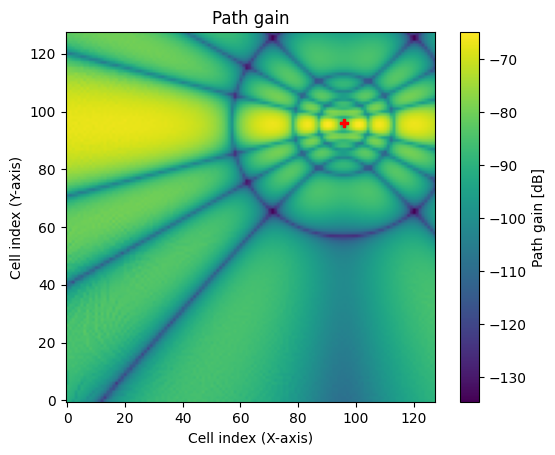

In [4]:
rm.show(metric="path_gain");
print(f'{rm.path_gain.shape=}') # Path gain
print(rm.path_gain)

In [5]:
# Remove transmitters here so that the cell can be executed multiple times
scene.remove("tx1")
scene.remove("tx2")

tx1 = Transmitter(name='tx1',
                  position=[-150, -100, 20],
                  orientation=[np.pi/6, 0, 0],
                  power_dbm=21)
scene.add(tx1)

tx2 = Transmitter(name='tx2',
                  position=np.array([0, 150 * np.tan(np.pi/3) - 100, 20]),
                  orientation=[-np.pi/2, 0, 0],
                  power_dbm=27)
scene.add(tx2)

rm = rm_solver(scene,
               max_depth=5,
               samples_per_tx=10**7,
               cell_size=(5, 5),
               center=[0, 0, 0],
               size=[400, 400],
               orientation=[0, 0, 0])

As soon as there are multiple transmitters in a scene, we can either visualize
a metric for specific transmitter or visualize the maximum metric across all
transmitters. The latter option is relevant if we want to inspect, e.g., the SINR across a large
scene, assuming that a receiver always connects to the transmitter providing
the best SINR.

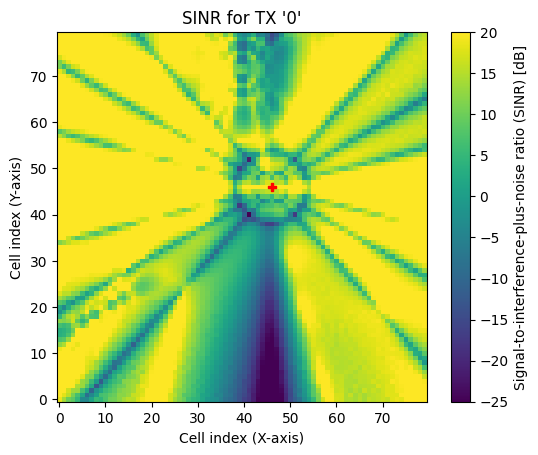

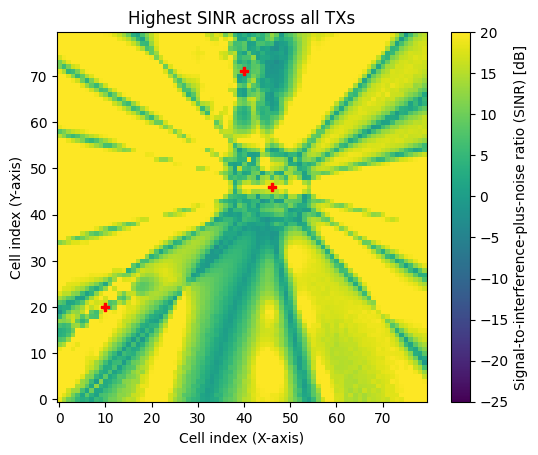

In [6]:
# Show SINR for tx0
rm.show(metric="sinr", tx=0, vmin=-25, vmax=20);

# Show maximum SINR across all transmitters
rm.show(metric="sinr", tx=None, vmin=-25, vmax=20);

# Experiment: Change the metric to "path_gain" or "rss"
#             and play around with the parameters vmin/vmax
#             that determine the range of the colormap

### User association

It is also interesting to investigate which regions of a radio map are "covered" by each transmitter, i.e., where a transmitter provides the strongest metric.
You can obtain this information either as a tensor from the class method [tx_association()](https://nvlabs.github.io/sionna/rt/api/radio_maps.html#sionna.rt.RadioMap.tx_association) or visualize it using [show_association()](https://nvlabs.github.io/sionna/rt/api/radio_maps.html#sionna.rt.RadioMap.show_association).

rm.tx_association("sinr").shape=(80, 80)


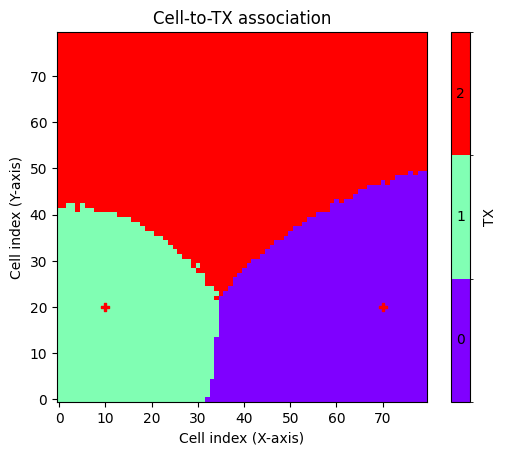

In [ ]:
# Get for every cell the tx index providing the strongest value
# of the chosen metric
# [num_cells_y, num_cells_x]
print(f'{rm.tx_association("sinr").shape=}')

rm.show_association("sinr");

### Sampling of random user positions

In some cases, one may want to drop receivers at random positions in a scene
while ensuring that the chosen positions have sufficient signal quality
(e.g., SINR)
and/or or are located within a certain range of a transmitter. The class
method [sample_positions()](https://nvlabs.github.io/sionna/rt/api/radio_maps.html#sionna.rt.RadioMap.sample_positions) is designed for this purpose, and you will see in the next
cell how it can be used.

You are encouraged to understand why the two different criteria used for sampling lead to the observed results.

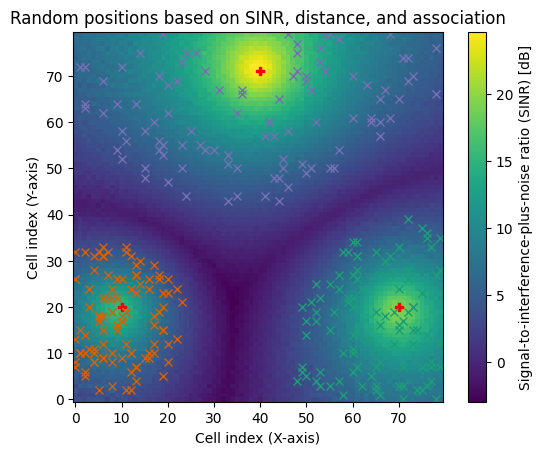

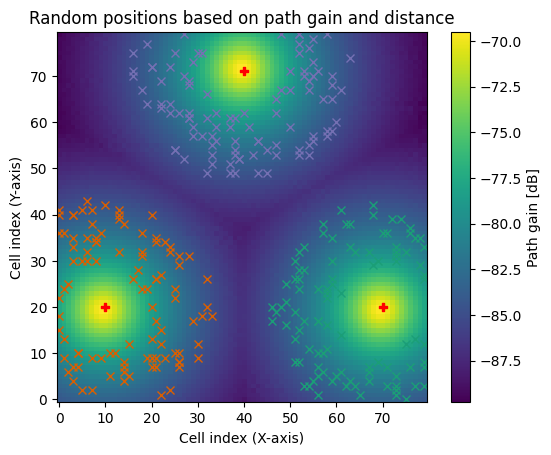

In [ ]:
pos, cell_ids = rm.sample_positions(
          num_pos=100,         # Number of random positions per receiver
          metric="sinr",       # Metric on which constraints and TX association will be applied
          min_val_db=3,        # Mininum value for the chosen metric
          max_val_db=20,       # Maximum value for the chosen metric
          min_dist=10,         # Minimum distance from transmitter
          max_dist=200,        # Maximum distance from transmitter
          tx_association=True, # If True, only positions associated with a transmitter are chosen,
                               # i.e., positions where the chosen metric is the highest among all TXs
          center_pos=False)    # If True, random positions correspond to cell centers,
                               # otherwise a random offset within each cell is applied

fig = rm.show(metric="sinr");
plt.title("Random positions based on SINR, distance, and association")
# Visualize sampled positions
for tx, ids in enumerate(cell_ids.numpy()):
    fig.axes[0].plot(ids[:,1], ids[:,0],
                     marker='x',
                     linestyle='',
                     color=mpl.colormaps['Dark2'].colors[tx])


pos, cell_ids = rm.sample_positions(
          num_pos=100,          # Number of random positions per receiver
          metric="path_gain",   # Metric on which constraints will be applied
          min_val_db=-85,        # Mininum value for the chosen metric
          min_dist=50,          # Minimum distance from transmitter
          max_dist=200,         # Maximum distance from transmitter
          tx_association=False, # If False, then a user located in a sampled position
                                # for a specific TX may perceive a higher metric from another TX!
          center_pos=False)     # If True, random positions correspond to cell centers,
                                # otherwise a random offset within each cell is applied

fig = rm.show(metric="path_gain");
plt.title("Random positions based on path gain and distance")
# Visualize sampled positions
for tx, ids in enumerate(cell_ids.numpy()):
    fig.axes[0].plot(ids[:,1], ids[:,0],
                     marker='x',
                     linestyle='',
                     color=mpl.colormaps['Dark2'].colors[tx])

### Directional antennas and precoding vectors

As mentioned above, radio maps heavily depend on the chosen antenna patterns and precoding vectors.
In the next cell, we will study their impact on a radio map via several visualizations.

Let us start by assigning a single antenna to all transmitters and computing the
corresponding radio map:

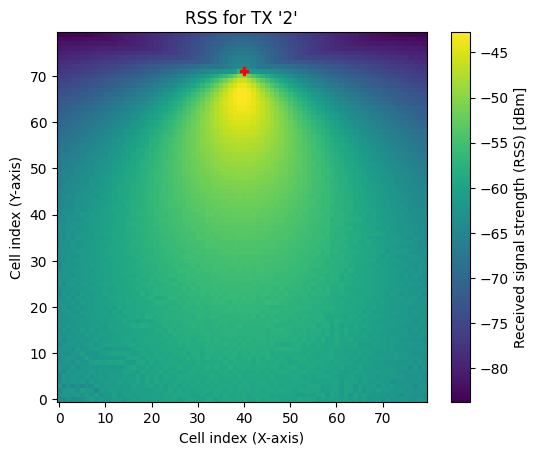

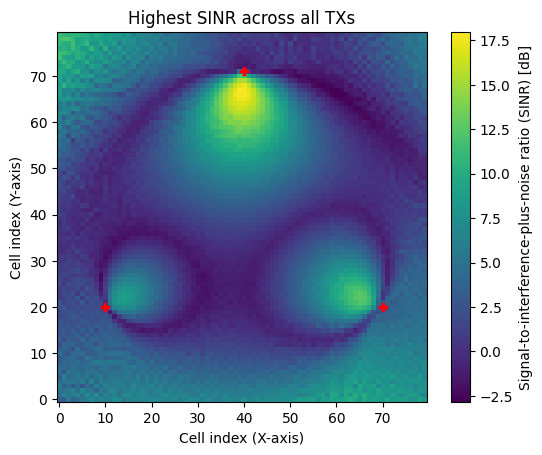

In [ ]:
scene.tx_array = PlanarArray(num_rows=1,
                             num_cols=1,
                             vertical_spacing=0.5,
                             horizontal_spacing=0.5,
                             pattern="tr38901",   # Change to "iso" and compare the results
                             polarization="V")

rm = rm_solver(scene,
               max_depth=5,
               samples_per_tx=10**7,
               cell_size=(5, 5),
               center=[0, 0, 0],
               size=[400, 400],
               orientation=[0, 0, 0])

rm.show(metric="rss", tx=2);

rm.show(metric="sinr");

We now add more antennas to the antenna array of the transmitters and apply a
precoding vector chosen from a Discrete Fourier Transform (DFT) beam grid.

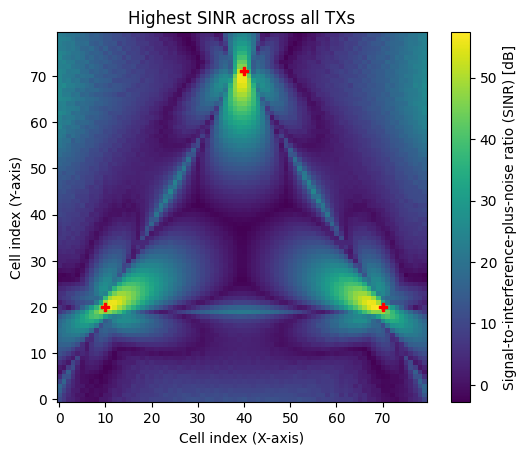

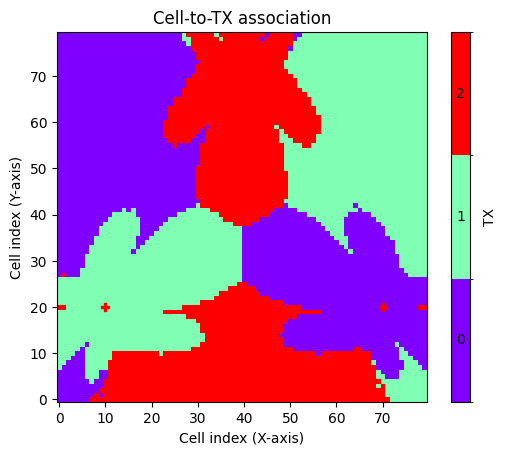

In [ ]:
# Number of elements of the rectangular antenna array
num_rows = 2
num_cols = 4

# Configure all transmitters to have equal power
tx0.power_dbm = 23
tx1.power_dbm = 23
tx2.power_dbm = 23

# Configure tr38901 uniform rectangular antenna array for all transmitters
scene.tx_array = PlanarArray(num_rows=num_rows,
                             num_cols=num_cols,
                             pattern="tr38901",
                             polarization="V")

# Create a common precoding vector used by all transmitters
# It is also possible to assign individual
precoding_vec = [1, -1]*4 / np.sqrt(8)

# Convert to tuple of Mitsuba vectors
precoding_vec = (mi.TensorXf(precoding_vec.real),
                 mi.TensorXf(precoding_vec.imag))

# Compute the radio map
rm = rm_solver(scene,
               max_depth=5,
               samples_per_tx=10**7,
               precoding_vec=precoding_vec,
               cell_size=(5, 5),
               center=[0, 0, 0],
               size=[400, 400],
               orientation=[0, 0, 0])

rm.show(metric="sinr");
rm.show_association(metric="sinr");

The use of antenna arrays and precoding vectors leads to complicated, even
artistic looking, radio maps with sometimes counter-intuitive regions of user
association. Nevertheless, we can still sample user positions for each transmitter.

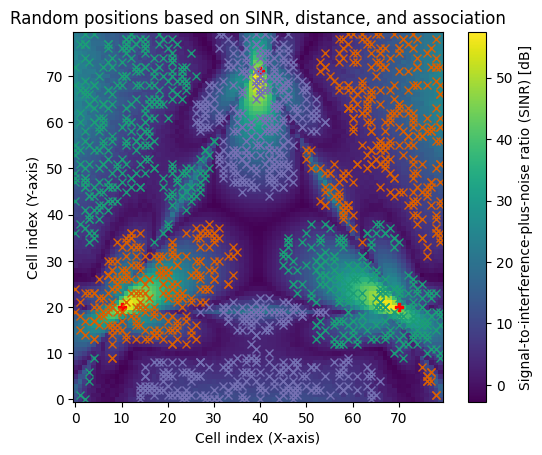

In [ ]:
pos, cell_ids = rm.sample_positions(
          num_pos=500,
          metric="sinr",
          min_val_db=3,
          min_dist=10,
          tx_association=True)

fig = rm.show(metric="sinr");

# Visualize sampled positions
for tx, ids in enumerate(cell_ids.numpy()):
    fig.axes[0].plot(ids[:,1], ids[:,0],
                     marker='x',
                     linestyle='',
                     color=mpl.colormaps['Dark2'].colors[tx])
plt.title("Random positions based on SINR, distance, and association");